### Created by: Anthony D. Cho
### Last update: 24.12.2021

**Subject**: Grad Cam (VGG19 - keras, tensorflow) - golfish

## Libraries dependencies

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from numpy import uint8, arange

## Keras tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import decode_predictions, preprocess_input

### Customized function

In [ ]:
def image2tensor(img_path, reshape):
    """
        DESCRIPTION:
            This function is responsible to load a RGB-image as a tensor

        INPUT:
            @param img_path: image path
            @type img_path: str

            @param reshape: image resizing shape
            @type reshape: tuple

        OUTPUT:
            @param tensor: image tensor
            @type tensor: numpy.ndarray
    """

    ## load image as a PIL image (RGB) of size (size, size)
    img = load_img(img_path, color_mode='rgb', target_size=reshape)

    ## Convert img to a 3D tensor (size, size, 3)
    tensor = img_to_array(img)

    ## Include batch dimension to tensor, providing (1, size, size, 3)
    tensor = tensor[tf.newaxis, :]

    ## return tensor
    return tensor

def gradCam_heatmap(img_array, 
                    model, last_conv_layer_name, 
                    pred_index=None):
    """
        DESCRIPTION:
            Grad-CAM class activation visualization (From Keras - FChollet)
            
        INPUT:
            @param img_array: image as tensor
            @type img_array: numpy.ndarray

            @param model: CNN model
            @type model: tensorflow.keras.engine.functional.Functional

            @param last_conv_layer_name: layer name
            @type last_conv_layer_name: str

            @param pred_index: prediction index (default is None)
            @type pred_index: int

        OUTPUT:
            @param heatmap: 
            @type heatmap: numpy.ndarray
    """

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:

        ## Compute output and prediction using the model
        last_conv_layer_output, predictions = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    ## return heatmap
    return heatmap.numpy()

def display_gradCam(img_path, heatmap, alpha=0.4, 
                    name='temp', save=False):
    """
        DESCRIPTION:
            Combine heatmap and the image

        INPUT:
            @param img_path: image path
            @type img_path: str

            @param heatmap: heatmap matrix
            @type heatmap: numpy.ndarray

            @param alpha: 
            @type alpha: float

            @param name: file name to save
            @type name: str

            @param save: save images
            @type save: bool

        OUTPUT: 
            @param original_img: original image
            @type original_img: PIL.Image.Image

            @param superimposed_img: heatmapped image
            @type superimposed_img: PIL.Image.Image
    """

    ## load image as a PIL image (RGB)
    img = load_img(img_path, color_mode='rgb')
    img = img_to_array(img)
    original_img = array_to_img(img)

    # Rescale heatmap to a range 0-255
    heatmap = uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    if save:
        original_img.save(f'{name}_original.jpg')
        original_img.save(f'{name}_superimposed.jpg')

    return original_img, superimposed_img

**List of 1000 Classes:** [Imagenet](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)

### Image loading and pre-processing

(shape) image-tensor: (1, 224, 224, 3)



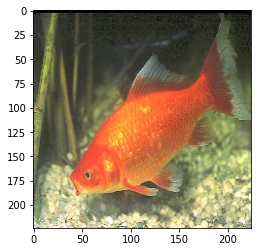

In [ ]:
## Download image from a source path
img_path = get_file(fname='goldfish.jpg', 
                    origin='https://github.com/adoc-box/Images/raw/main/goldfish.jpg')

## The default input size for VGG19 model is 224x224.
resize = (224, 224)

## load image as tensor
img_tensor = image2tensor(img_path, resize)

## Display tensor shape
print('(shape) image-tensor: {}\n'.format(img_tensor.shape))

## Display RGB-image
plt.imshow(img_tensor[0]/255.0);

Predicted: [('n01443537', 'goldfish', 36.862995)]


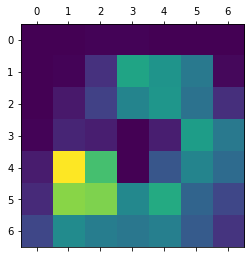

In [ ]:
## Model instance
model = VGG19(weights="imagenet")

## Last convolutional layer name
last_conv_layer_name = 'block5_pool'

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
predictions = model.predict(preprocess_input( img_tensor ))
print("Predicted:", decode_predictions(predictions, top=1)[0])

# Generate class activation heatmap
heatmap = gradCam_heatmap(img_tensor, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
original_img, mapped_img = display_gradCam(img_path, heatmap, alpha=0.8)

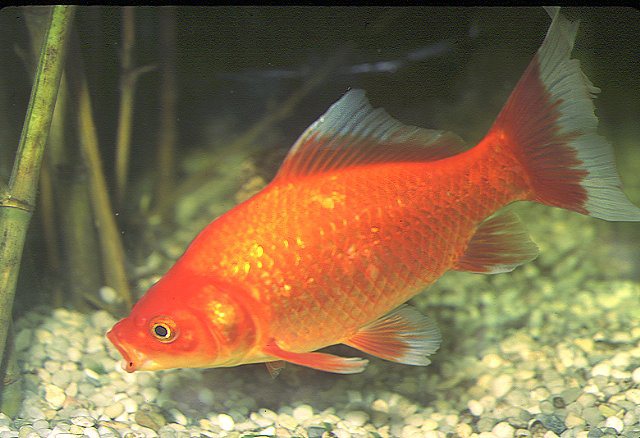

In [ ]:
original_img

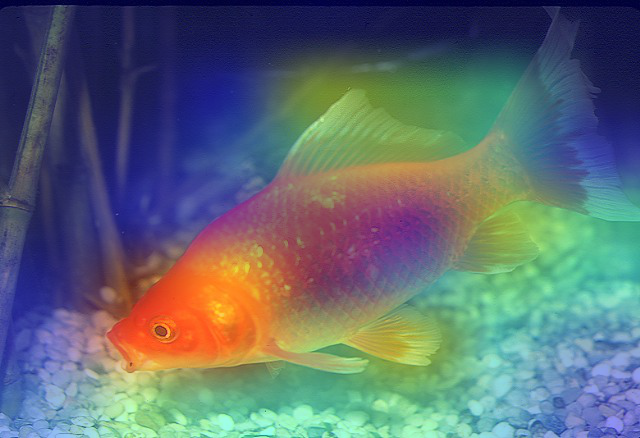

In [ ]:
mapped_img